In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
old_data = pd.read_csv("cleaned_data.csv")
old_data.head()

,Unnamed: 0,text,label
0,0,витино кингисепп дорога идеальный,Дорога с идеальным или близким к идеальному по...
1,1,качество покрытие отличный постоянно ремонт ул...,Дорога с идеальным или близким к идеальному по...
2,2,трасса зеркало видимо давно обновлять инф,Дорога с идеальным или близким к идеальному по...
3,3,чистить асфальт ровный выбоина,Дорога с идеальным или близким к идеальному по...
4,4,отличный дорога,Дорога с идеальным или близким к идеальному по...


In [3]:
labels = old_data['label'].unique()[:-1]
data = old_data.loc[old_data.label.isin(labels)]
data = data[data['text'].apply(type) == str]

In [4]:
data['label'].replace(labels[0], 1, inplace=True)
data['label'].replace(labels[1:], 0, inplace=True)
X_texts = data['text'].tolist()
X_tokens = [x.split() for x in X_texts]
y_data = data['label'].tolist()

0.9923495067445138

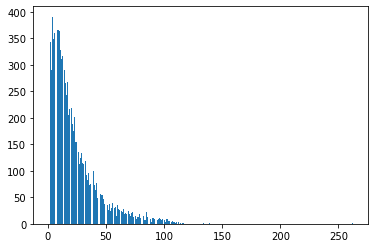

In [5]:
from collections import Counter
from matplotlib import pyplot as plt
lens = [len(x.split()) for x in X_texts]
len_counter = Counter(lens)
plt.bar(len_counter.keys(), len_counter.values())
len([l for l in lens if l < 100]) / len(lens)

In [6]:
from gensim.models import Word2Vec

nemb = 300 # размер вектора слова
w2v_model = Word2Vec(min_count=1, window=5, vector_size=nemb, sample=6e-5, 
                     alpha=0.03, min_alpha=0.0004, negative=20, workers=6)
w2v_model.build_vocab(X_tokens) # требует список из списков токенов

In [155]:
from gensim.models import Word2Vec
w2v_model_google = Word2Vec(min_count=1, window=5, vector_size=300, sample=6e-5, alpha=0.03, min_alpha=0.0001, negative=20, workers=8)
w2v_model_google.build_vocab(X_tokens)
w2v_model_google.wv.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
w2v_model_google.train(X_tokens, total_examples=w2v_model.corpus_count, epochs=15)

(1657922, 3339255)

In [7]:
w2v_model.train(X_tokens, total_examples=w2v_model.corpus_count, epochs=70)

(7740528, 15583190)

In [8]:
w2v_model.wv.most_similar('плохо')

[('каракл', 0.5516131520271301),
 ('шихазан', 0.5344586372375488),
 ('заезды-выезд', 0.519331693649292),
 ('вельский', 0.48651832342147827),
 ('паркет', 0.469946026802063),
 ('обочины-ехать', 0.46308261156082153),
 ('3-4км', 0.4561167359352112),
 ('расчистка', 0.45162275433540344),
 ('стремноватый', 0.4489523470401764),
 ('-30', 0.4469297230243683)]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# перед использованием списки слов будут объединены в одну строку
tfidf = TfidfVectorizer(preprocessor=' '.join) 
X_data = tfidf.fit_transform(X_tokens) # требует лист из строк

In [10]:
# построение словаря: слово -> вектор длины nemb
embedding_matrix = np.zeros((len(tfidf.vocabulary_.items()), nemb), dtype=np.float32)
for word, i in tfidf.vocabulary_.items():
    if word in w2v_model.wv.index_to_key:
        embedding_matrix[i] = w2v_model.wv[word]

In [11]:
# вместо простого усреднения последовательности погруженных векторов
# будем использовать усреднение с весами tf-idf 
X_data = X_data @ embedding_matrix

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42, shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [14]:
# Метод опорных векторов с подбором оптимальных гиперпараметров
from sklearn.svm import SVC
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import GridSearchCV
import multiprocessing

params = {'C': [0.01, 0.1, 1, 10, 12, 13, 15],
          'kernel': ['linear', 'poly', 'rbf']}

clf = SVC(random_state=42)
grid_SVM = GridSearchCV(clf, params, n_jobs=8, scoring='f1')
grid_SVM.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 12, 13, 15],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1')

In [15]:
from sklearn.metrics import classification_report
y_pred = grid_SVM.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
grid_SVM.best_params_

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       784
           1       0.80      0.68      0.74       210

    accuracy                           0.90       994
   macro avg       0.86      0.82      0.84       994
weighted avg       0.89      0.90      0.89       994



{'C': 15, 'kernel': 'rbf'}

In [16]:
import pickle
with open("model_svm_74_70", 'wb') as file:
    pickle.dump(grid_SVM.best_estimator_, file)